# Imports and setup

In [1]:
from IPython.display import display, HTML
from IPython.display import clear_output
from pyspark.sql import SparkSession
from pyspark.sql import functions as f
from pyspark.sql.functions import col,lit
import pandas
display(HTML("<style>div.output_scroll { height: 80em; }</style>"))

# Scaling performance timings

In [5]:
spark_session.stop()

The runtime of the process with 4core executor is: 362.19009017944336s


The runtime of the process with 8core executor is: 187.94460368156433s


The runtime of the process with 12core executor is: 141.85714030265808s


The runtime of the process with 16core executor is: 124.82891011238098s


The runtime of the process with 20core executor is: 108.29522466659546s


The runtime of the process with 24core executor is: 101.7833788394928s


<Axes: title={'center': 'Distribution of all comments from 2006 to 2011 inside a day'}, xlabel='hour'>

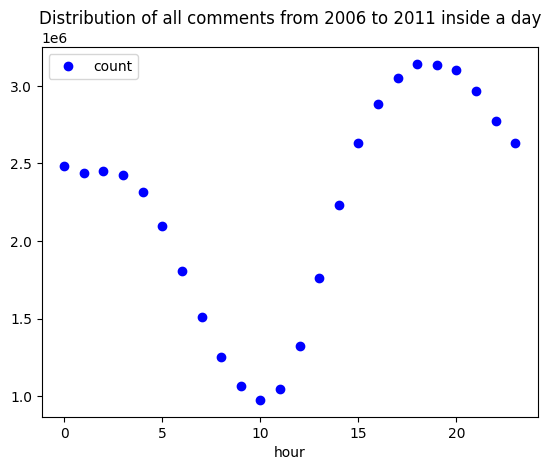

In [13]:
import time
times=[]
for i in [4,8,12,16,20,24]:
    start=time.time()
    ### don't mess with this! ###
    driverIP = !(hostname -I)
    driverIP = driverIP[0].strip() # ip adress of the container running this app, needed for Spark to work

    spark_session = SparkSession.builder\
    .master("spark://sparknet:7077") \
    .config("spark.driver.bindAdress","0.0.0.0")\
    .config("spark.driver.host",f"{driverIP}")\
    .config("spark.driver.port","8900")\
    .config("spark.cores.max", i)\
    .config("spark.executor.memory", "1024m")\
    .appName("test_analysis_c"+str(i))\
    .getOrCreate()

    #load data
    df=spark_session.read.json("hdfs://hadoopnet:9000/user/root/reddit-comments")
    df.drop('archived','controversiality','author_flair_css_class', 'author_flair_text', 'distinguished', 'downs', 'edited', 'gilded', 'id', 'link_id', 'parent_id', 'removal_reason', 'retrieved_on', 'score', 'score_hidden', 'stickied', 'subreddit', 'subreddit_id', 'ups')
    date = df.withColumn("timestamp",f.to_timestamp(df['created_utc'].cast('long')))

    #Analysis
    ## distribution of comments inside a day
    d=((date.where("author <> '[deleted]'")).groupBy(f.hour("timestamp").alias("hour")).count()).toPandas()
    #d=df2.toPandas()
    d.sort_values(by="hour")
    spark_session.stop()
    end=time.time()
    times.append(end-start)
    print("The runtime of the process with "+str(i)+"core executor is: "+str(end-start)+"s")
    
d.plot(x="hour", y='count', style='bo', title="Distribution of all comments from 2006 to 2011 inside a day" )

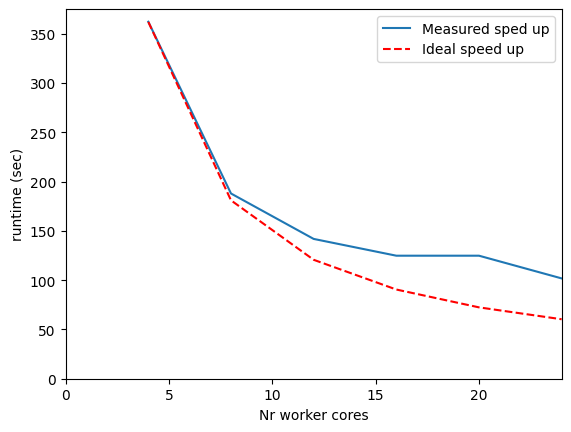

In [24]:
#Plotting runtime results
times=[362.19, 187.94, 141.85,  124.82, 124.82, 101.78]
import matplotlib.pyplot as plt
plt.plot([4,8,12,16,20,24],times,label='Measured sped up')
plt.plot([4,8,12,16,20,24],[362,362/2,362/3,362/4,362/5,362/6], '--r', label='Ideal speed up' )
plt.legend()
plt.axis([0, 24, 0, 375])
plt.xlabel("Nr worker cores")
plt.ylabel("runtime (sec)")
plt.show()

# Setting up further analyssis
 - Spark session
 - load HDF data
 - convert ephoch to date
 - Overall object count
 - dropp unnecesary column from schema

In [25]:
### don't mess with this! ###
driverIP = !(hostname -I)
driverIP = driverIP[0].strip() # ip adress of the container running this app, needed for Spark to work

spark_session = SparkSession.builder\
.master("spark://sparknet:7077") \
.config("spark.driver.bindAdress","0.0.0.0")\
.config("spark.driver.host",f"{driverIP}")\
.config("spark.driver.port","8900")\
.appName("test_analysis")\
.getOrCreate()

In [26]:
df=spark_session.read.json("hdfs://hadoopnet:9000/user/root/reddit-comments")

In [27]:
print("Overall object count: "+str(df.count()))
df.printSchema()

Overall object count: 71502863
root
 |-- archived: boolean (nullable = true)
 |-- author: string (nullable = true)
 |-- author_flair_css_class: string (nullable = true)
 |-- author_flair_text: string (nullable = true)
 |-- body: string (nullable = true)
 |-- controversiality: long (nullable = true)
 |-- created_utc: string (nullable = true)
 |-- distinguished: string (nullable = true)
 |-- downs: long (nullable = true)
 |-- edited: string (nullable = true)
 |-- gilded: long (nullable = true)
 |-- id: string (nullable = true)
 |-- link_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- parent_id: string (nullable = true)
 |-- removal_reason: string (nullable = true)
 |-- retrieved_on: long (nullable = true)
 |-- score: long (nullable = true)
 |-- score_hidden: boolean (nullable = true)
 |-- stickied: boolean (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- subreddit_id: string (nullable = true)
 |-- ups: long (nullable = true)



In [28]:
#dropping unnecesary data elements
df.drop('archived','controversiality','author_flair_css_class', 'author_flair_text', 'distinguished', 'downs', 'edited', 'gilded', 'id', 'link_id', 'parent_id', 'removal_reason', 'retrieved_on', 'score', 'score_hidden', 'stickied', 'subreddit', 'subreddit_id', 'ups').printSchema()

root
 |-- author: string (nullable = true)
 |-- body: string (nullable = true)
 |-- created_utc: string (nullable = true)
 |-- name: string (nullable = true)



In [29]:
#Convert epoch to date and group by 
date = df.withColumn("timestamp",f.to_timestamp(df['created_utc'].cast('long')))

# Analytic tool for plotting over time
 - Overall post count
 - Occurance of specific word inside posts
 - Plotting for periodic occurance inside a day, month or year
 - Plotting occurance over time with timstep: hour, day, month, year

<Axes: title={'center': 'Trending per day from 2006 to 2011\n (overall reddit post count)'}, ylabel='number of posts'>

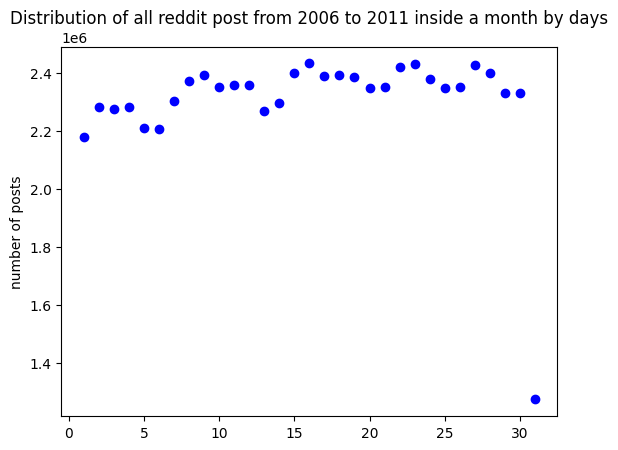

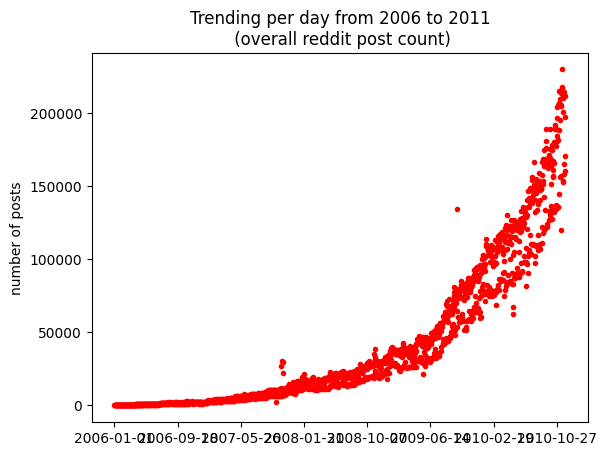

In [54]:
#Procedur for periodic distribution and trending over time
print("Give one of the following: \"hour\", \"day\", \"month\", \"year\"")
name=input()
while name not in ["hour", "day", "month", "year"]:
    clear_output(wait=False)
    print("Give one of the following: \"hour\", \"day\", \"month\", \"year\"")
    name=input()

if name=="hour":
    func=f.hour
    form='yyyy-MM-dd HH'
    session='day by hours'
    si=1
elif name=="day":
    func=f.dayofmonth
    form='yyyy-MM-dd'
    session='month by days'
    si=3
elif name=="month":
    func=f.month
    form='yyyy-MM'
    session='year by month'
    si=5
elif name=="year":
    func=f.year
    form='yyyy'
    session="period of years"
    si=10

## distribution of comments inside a day
clear_output(wait=False)
df2=date.groupBy(func("timestamp").alias(name)).count()
d=df2.toPandas()
d.sort_values(by=name)
d.plot(x=name, y='count', style='bo', title="Distribution of all reddit post from 2006 to 2011 inside a "+session, xlabel="", ylabel="number of posts", legend=False)

## Change over period (day) overall comments
df2=date.select(f.date_format('timestamp',form).alias(name)).groupby(name).count()
d=df2.toPandas()
d=d.sort_values(by=name)
d.plot(x=name, y='count', style='ro',ms=si, title="Trending per "+name +" from 2006 to 2011\n (overall reddit post count)", xlabel="", ylabel="number of posts", legend=False)

<Axes: title={'center': 'Trending per month from 2006 to 2011\n Wordcount for the word: reddit'}, ylabel='number of posts'>

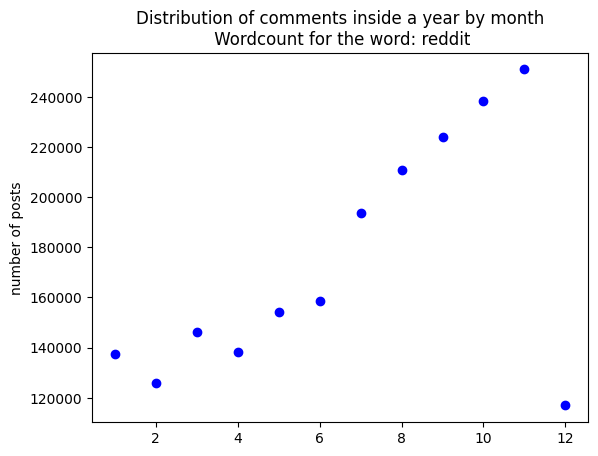

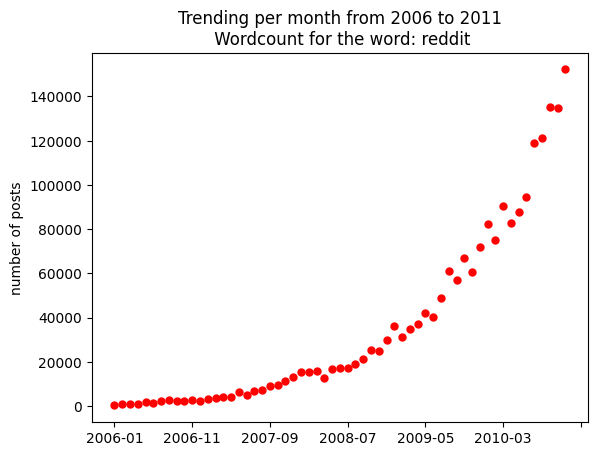

In [8]:
## Getting words separated, get rid of special characters and convert to lowercaese for analysis

df3=date.withColumn("body", f.regexp_replace(date.body, "[^a-zA-Z0-9]", " "));
raw_words=df3.withColumn('body',f.explode(f.split('body',' ')))
words = raw_words.withColumn('body', f.lower(f.trim(raw_words.body)))


#Read searched word and filter data for it
print("Give the searched key word:")
word=str.lower(input())
dff=words.filter(words.body==word)


#Same procedur for periodic distribution and trending over time
print("Give one of the following: \"hour\", \"day\", \"month\", \"year\"")
name=input()
while name not in ["hour", "day", "month", "year"]:
    clear_output(wait=False)
    print("Give one of the following: \"hour\", \"day\", \"month\", \"year\"")
    name=input()

if name=="hour":
    func=f.hour
    form='yyyy-MM-dd HH'
    session='day by hours'
    si=1
elif name=="day":
    func=f.dayofmonth
    form='yyyy-MM-dd'
    session='month by days'
    si=3
elif name=="month":
    func=f.month
    form='yyyy-MM'
    session='year by month'
    si=5
elif name=="year":
    func=f.year
    form='yyyy'
    session="period of years"
    si=10
        
## distribution of comments inside a day
clear_output(wait=False)
df2=dff.groupBy(func("timestamp").alias(name)).count()
d=df2.toPandas()
d.sort_values(by=name)
d.plot(x=name, y='count', style='bo', title="Distribution of comments inside a "+session+"\n Wordcount for the word: "+word, xlabel="", ylabel="number of occurance", legend=False)

## Change over period (day) overall comments

df2=dff.select(f.date_format('timestamp',form).alias(name)).groupby(name).count()
d=df2.toPandas()
d=d.sort_values(by=name)
d.plot(x=name, y='count', style='ro', ms=si, title="Trending per "+name+" from 2006 to 2011\n Wordcount for the word: "+word, xlabel="", ylabel="number of occurance", legend=False)

# Analytic tool for plotting CDF CDF plot of posts and population
 - Additional plotting of which percantage of people do the top 20% of posts

In [40]:
df5=(df.where("author <> '[deleted]'")).groupBy(df.author).count() 
top10=df5.sort(col('count').desc()).toPandas()
df6=df5.groupBy(df5['count'].alias('nr_post')).count()
pand=df6.toPandas()

The 80% of posts comes from the 0.1887741393208242% of users


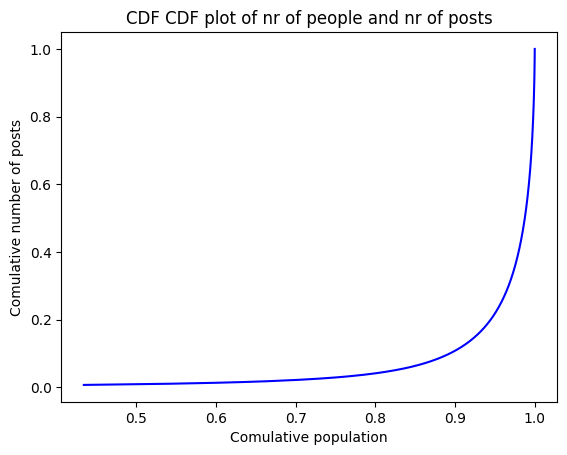

In [47]:
pand=pand.sort_values(by='nr_post')
pand['count_post']=pand['nr_post']*pand['count']
cdf=pandas.DataFrame()
cdf['nr_people']=pand['count'].cumsum()
cdf['count_post']=pand['count_post'].cumsum()
cdf['nr_people']=cdf['nr_people']*(1/cdf['nr_people'].max())
cdf['count_post']=cdf['count_post']*(1/cdf['count_post'].max())
cdf.plot(x='nr_people', y='count_post', style='-b', title="CDF CDF plot of nr of people and nr of posts", xlabel="Comulative population", ylabel="Comulative number of posts", legend=False)
print("The 80% of posts comes from the "+str(100*(1-cdf.loc[cdf['count_post']>0.8]['nr_people'].min()))+"% of users")


In [46]:
top10=top10.head(10)
print("TOP 10 author and the number of their posts")
top10

TOP 10 author and the number of their posts


,author,count
0,NoMoreNicksLeft,53039
1,malcontent,45062
2,matts2,42486
3,insomniac84,38218
4,AnnArchist,30521
5,AMerrickanGirl,30518
6,IConrad,29228
7,mutatron,28100
8,mexicodoug,27641
9,eaturbrainz,26619


In [66]:
spark_session.stop()